In [4]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import fetch_mldata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn import metrics
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_mldata('MNIST original')
normalized_dataset = np.divide(mnist.data,1)
mnist_data = normalized_dataset
mnist_target_data = mnist.target



In [7]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [8]:
def area(p0,p1):
    A = p0
    D = p1
    B = [A[0],D[1]]
    C = [D[0],A[1]]
    #return (distance(C,A)*distance(C,D))
    return ((C[0]-A[0])*(D[1] - C[1]))

In [5]:
random_rectangles = []
def generate_rectangles():
    count = 1
    
    while count<=100:
        p0 = []
        p1 = []
        p0.append(np.random.randint(27))
        p0.append(np.random.randint(27))
        p1.append(np.random.randint(27))
        p1.append(np.random.randint(27))
        
        c = [p0,p1]
        if (c in random_rectangles):
            continue
        
                
        if ((p0[0] < p1[0]) and (p0[1] < p1[1])):
            if (not(area(p0,p1)<=170 and area(p0,p1)>=130)):
                continue
            random_rectangles.append(c)
            count+=1
                
        elif ((p0[0] > p1[0]) and (p0[1] > p1[1])):
            if (not(area(p0,p1)<=170 and area(p0,p1)>=130)):
                continue
            c = [p1,p0]
            random_rectangles.append(c)
            count+=1
        
    
        
            
    print(random_rectangles)
        
    

In [6]:
generate_rectangles()

[[[8, 4], [23, 13]], [[16, 0], [25, 15]], [[3, 11], [20, 19]], [[5, 11], [21, 20]], [[4, 8], [17, 21]], [[3, 13], [15, 25]], [[1, 18], [18, 26]], [[3, 3], [15, 15]], [[10, 6], [19, 23]], [[13, 9], [24, 23]], [[2, 4], [14, 17]], [[10, 2], [23, 13]], [[6, 9], [25, 17]], [[10, 6], [24, 16]], [[8, 9], [21, 21]], [[0, 12], [15, 21]], [[9, 14], [26, 22]], [[7, 13], [26, 21]], [[0, 7], [12, 19]], [[10, 0], [17, 19]], [[14, 4], [24, 20]], [[0, 6], [11, 20]], [[6, 4], [14, 23]], [[0, 8], [13, 20]], [[11, 9], [26, 19]], [[1, 4], [12, 19]], [[1, 3], [24, 9]], [[8, 0], [26, 9]], [[0, 15], [15, 25]], [[11, 3], [18, 25]], [[3, 15], [22, 22]], [[12, 2], [20, 21]], [[16, 2], [26, 18]], [[2, 13], [17, 24]], [[1, 2], [23, 9]], [[4, 1], [15, 16]], [[12, 3], [25, 13]], [[10, 5], [19, 21]], [[11, 6], [24, 19]], [[14, 4], [24, 21]], [[7, 7], [22, 16]], [[5, 11], [14, 26]], [[8, 4], [16, 23]], [[6, 4], [13, 26]], [[7, 8], [16, 23]], [[0, 13], [15, 23]], [[9, 3], [23, 15]], [[10, 14], [23, 24]], [[11, 10], [2

In [84]:
print(len(random_rectangles))

100


In [13]:
def half_point(p1,p2,axis):
    
    if axis == 0: #half the x coordinate
        return [(p1[0]+p2[0])//2,p1[1]]
    if axis == 1: #half the y coordinate
        return [p1[0],(p1[1]+p2[1])//2]

In [12]:
def black(image):
    #first compute black(diag-rectangle OR)
    #D = R
    #C = Q
    #print("A:",A)
    #print("B:",B)
    #print("C:",C)
    #print("D:",D)
    #DP implementation of corner rectangle
    rows = image.shape[0]
    columns = image.shape[1]
    black = np.zeros((rows,columns))
    #print(black.shape)
    for j in range(columns):
            if image[0][j] > 0.:
                if j > 0:
                    black[0][j] = black[0][j-1] + 1
                else:
                    black[0][j] =  1
                
    for i in range(rows):
            #print("i:",i)
            #print("image[i][0]",image[i][0])
            if image[i][0] > 0.:
                #print(i,image[i])
                if i > 0:
                    black[i][0] = black[i-1][0] + 1
                else:
                    black[i][0] = 1
                #print(i,black[i])
    #print("black initialized:black[0]",black)
        
    for i in range(1,rows):
        for j in range(1,columns):
            black_dij = 0
            if image[i][j] > 0.:
                black_dij = 1
            black[i][j] = black[i][j-1] + black[i-1][j] - black[i-1][j-1] + black_dij
    
    return black
    

In [13]:
def compute_feature_val(black_matrix,A,B,C,D):
    #print(A,B,C,D)
    result = black_matrix[D[0]][D[1]] - black_matrix[B[0]][B[1]] - black_matrix[C[0]][C[1]] + black_matrix[A[0]][A[1]]
    return result

In [15]:
vertical_feature = []
horizontal_feature = []
point_idx = -1

new_data = np.zeros((mnist_data.shape[0],200))
for data in mnist_data:
    image = data.reshape(28,28)
    #step 1: first find black(rectangle-diag(OD)) for all rectangles using DP
    black_matrix = black(image)
    #print(black_matrix)
    point_idx+=1
    #print("point_idx:",point_idx)
    feature_idy = 0
    for each_rectangle in random_rectangles:
        #each_rectangle = [[1,1],[20,20]]
        tl = each_rectangle[0]
        br = each_rectangle[1]
        tr = [br[0],tl[1]]
        bl = [tl[0],br[1]]
        
        ml = half_point(tl,br,0) #0 for horizontal half
        mr = half_point(br,tr,0) 
        

        
        tm = half_point(tl,tr,1) #1 for vertical half
        bm = half_point(bl,br,1)
                    
        #step2: Once we have the blacks computed for the corned each_rectangle, black(each_rectangle) can be computed
                #i.e find black(ABQR) and black(QRCD) 
            #ABQR

        X1 = (black_matrix[mr[0],mr[1]] - black_matrix[tr[0],tr[1]] - black_matrix[ml[0],ml[1]] + black_matrix[tl[0],tl[1]])
            #QRCD

            
        X2 = (black_matrix[br[0],br[1]] - black_matrix[mr[0],mr[1]] - black_matrix[bl[0],bl[1]] + black_matrix[ml[0],ml[1]])
            #AMCN

        X3 = (black_matrix[bm[0],bm[1]] - black_matrix[tm[0],tm[1]] - black_matrix[bl[0],bl[1]] + black_matrix[tl[0],tl[1]])
            #MBND

        X4 = (black_matrix[br[0],br[1]] - black_matrix[tr[0],tr[1]] - black_matrix[bm[0],bm[1]] + black_matrix[tm[0],tm[1]])
        

        vf =  X1 - X2
        hf =  X3 - X4 
        #vf = X1 - (X - X1)
        #hf = X3 - (X - X3)
        #print("vf",vf)
        #print("hf",hf)
        #print("feature_idy:",feature_idy)
        
        #print((X - X1),compute_feature_val(black_matrix,Q,R,C,D))
        
        new_data[point_idx][feature_idy] = vf
        new_data[point_idx][feature_idy+1] = hf
        
        feature_idy+=2
    
    

In [16]:
def Logistic_Regression(X_train,X_test,y_train,y_test):
#     logreg = LogisticRegression()
#     logreg.fit(X_train, y_train)
    
#     y_pred = logreg.predict(X_test)
#     print(y_pred)
#     print("accuracy",logreg.score(X_test, y_pred))
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("score:",score)

In [17]:
def Decision_Trees(X_train,X_test,y_train,y_test):
    dectree = DecisionTreeClassifier(random_state=42)
    dectree.fit(X_train, y_train)
    
    y_pred = dectree.predict(X_test)
    print("accuracy",metrics.accuracy_score(y_test, y_pred))

In [20]:
mnistX_train, mnistX_test, mnisty_train, mnisty_test = train_test_split(new_data, mnist_target_data, test_size=1/7.0, random_state=0)
Logistic_Regression(mnistX_train, mnistX_test, mnisty_train, mnisty_test)
Decision_Trees(mnistX_train, mnistX_test, mnisty_train, mnisty_test)


score: 0.9112
accuracy 0.798


In [19]:
new_data.shape

(70000, 200)

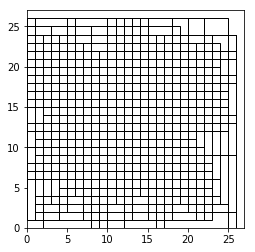

In [7]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, aspect='equal')
for each_r in random_rectangles:
    #A = [each_r[0][0]/float(255),each_r[0][1]/float(255)]
    #D = [each_r[1][0]/float(255),each_r[1][1]/float(255)]
    tl = each_r[0]
    br = each_r[1]
    tr = [br[0],tl[1]]
    bl = [tl[0],br[1]]
    
    lims = (0, 27)
    #height = distance(C,A)
    #width = distance(C,D)
    width = br[0] - tl[0]
    
    height = br[1] - tl[1]
    
    lims = (0, 27)
    ax2.add_patch(
    patches.Rectangle(
        (tl[0],tl[1]),
        width,
        height,
        fill=False      # remove background
    )
    )
    plt.ylim(lims)
    plt.xlim(lims)



In [11]:
dummy_rectangles = []
def generate_rectangles_dummy():
    count = 1
    
    while count<=100:
        p0 = []
        p1 = []
        p0.append(np.random.randint(27))
        p0.append(np.random.randint(27))
        p1.append(np.random.randint(27))
        p1.append(np.random.randint(27))
        
        c = [p0,p1]
        if (c in dummy_rectangles):
            continue
        
                
        if ((p0[0] < p1[0]) and (p0[1] < p1[1])):
            if (not(area(p0,p1)<=170 and area(p0,p1)>=130)):
                continue
            dummy_rectangles.append(c)
            count+=1
                
        elif ((p0[0] > p1[0]) and (p0[1] > p1[1])):
            if (not(area(p0,p1)<=170 and area(p0,p1)>=130)):
                continue
            c = [p1,p0]
            dummy_rectangles.append(c)
            count+=1
        
    
        
            
    #print(dummy_rectangles)

In [22]:
generate_rectangles_dummy()
each_r_ = dummy_rectangles[0]
tl = each_r_[0]
br = each_r_[1]
tr = [br[0],tl[1]]
bl = [tl[0],br[1]]
print(tl,br,tr,bl)
ml = half_point(tl,bl,1) #0 for horizontal half
mr = half_point(tr,br,1) 
tm = half_point(tl,tr,0) #1 for vertical half
bm = half_point(bl,br,0)
print(ml,mr,tm,bm)

[4, 10] [17, 20] [17, 10] [4, 20]
[4, 15] [17, 15] [10, 10] [10, 20]
